### 1. Модель без марковского переключения

### Модель и обозначения: 
$$y_t = \alpha + \epsilon_t$$
$$\epsilon_t = \sigma_t z_t$$
$$z_t \sim iid \mathcal{N}(0, 1)$$
$$\sigma_t^2 = \beta_0 + \beta_1 \epsilon_{t-1}^2 + \gamma \sigma_{t-1}^2$$


### Задача:
Дано: $(y_0, y_2, ..., y_T) = Y$ 

Оценить параметры $(\alpha, \beta_0, \beta_1, \gamma) = \theta$


In [1]:
import pandas as pd 
import numpy as np 
from scipy.stats import norm
import math as m
import matplotlib.pyplot as plt 

Matplotlib is building the font cache; this may take a moment.


правдоподобие: 
$$L(\theta| Y) = \Pi_{t = 1}^T (2\pi \sigma_t^2)^{-1/2} \exp(-\frac{1}{2\sigma_t^2}(y_t - \alpha)^2)$$ 
Надо выразить $\sigma_t$ через $y_t$ и найти argmax

$$\epsilon_t = y_t - \alpha$$
$$\sigma_t = \beta_0 + \beta_1 \epsilon_{t-1}^2 + \gamma\sigma_{t-1}^2 = \beta_0 + \beta_1 (y_{t-1} - \alpha)^2 + \gamma\sigma_{t-1}^2$$

$$\sigma_0^2 = \frac{\beta_0}{1 - \beta_1 - \gamma}$$

In [2]:
# функция выражает sigma_t по массиву y размера T 

def calc_sigmasq(t, y, theta): # y - массив значений y, T - размер массива значений, theta = параметры
    # в theta лежат параметры
    # выгружаем параметры
    alpha = theta[0]
    beta_0 = theta[1]
    beta_1 = theta[2]
    gamma = theta[3]

    sigmasq = [beta_0 / (1 - beta_1 - gamma)]
    for i in range(1, t + 1):
        sigmasq.append(beta_0 + beta_1 * (y[i - 1] - alpha)**2 + gamma * sigmasq[i - 1])
    return sigmasq

In [3]:
# надо посчитать правдоподобие при разных значениях [alpha, beta_0, beta_1, gamma] = theta и посчитать argmax

def calc_log_likelhood(t, y, theta):
    sigmasq = calc_sigmasq(t, y, theta) ## массив сигма square
    alpha = theta[0]
    logL = 0
    for i in range(t):
        add = m.log(norm.pdf(y[i], loc=alpha, scale=(sigmasq[i]**0.5))) # scale = \sqrt(var)
        logL += add
    return logL


In [4]:
def find_max_likelhood(t, y): 
    # надо сгенерировать массив параметров theta = [alpha, beta_0, beta_1, gamma] alpha \in [-1, 1], beta_0 in (0, 1], beta_1 in [0, 1], gamma in [0, 1]

    alpha_values = np.arange(-1, 1.1, 0.1)
    beta_0_values = np.arange(0.1, 1.1, 0.1)
    beta_1_values = np.arange(0, 1.1, 0.1)
    gamma_values = np.arange(0, 1.1, 0.1)

    theta_values = []
    for first in alpha_values:
        for second in beta_0_values:
            for third in beta_1_values:
                for fourth in gamma_values:
                    theta_values.append([first, second, third, fourth])


    L_values = []
    
    for theta in theta_values:
        L = calc_log_likelhood(t, y, theta)
        L_values.append(L)
    
    theta_index = np.argmax(L_values)

    return theta_values[theta_index], L_values

# find_max_likelhood(5, [0.2, 0.1, -0.02, -0.1, 0.012])


In [22]:
# генерим данные 
alpha = 0.5
beta_0 = 1
beta_1 = 0.3
gamma = 0.6 
sigma_0sq = (beta_0 / (1 - beta_1 - gamma)) # попробуем делать массив sigma^2

z = norm.rvs(loc=0, scale=1, size=1000, random_state=42) # вектор z_t

# посчитаем массив sigma, epsilon
sigmasq = [sigma_0sq]
epsilon = [sigmasq[0] * z[0]]
for i in range(1, len(z)):
    sigmasq.append(beta_0 + beta_1 * epsilon[i - 1]**2 + gamma * sigmasq[i - 1])
    epsilon.append((sigmasq[i] ** 0.5) * z[i])

# посчитаем массив y
y = []
for i in range(len(z)):
    y.append(alpha + epsilon[i])

print(len(y))
print(len(z))
print(len(epsilon))
print(len(sigmasq))

1000
1000
1000
1000


In [7]:
from scipy.optimize import minimize

start_theta = [0.1, 0.1, 0.1, 0.1]

def optimize_function(theta):
    return -1 * calc_log_likelhood(t=1000, y=y, theta=theta)

result = minimize(optimize_function, start_theta, bounds=[(0.01, 0.6), (0, 1.5), (0, 0.34), (0, 0.64)])

print(f'Параметры после оптимизации: alpha = {result.x[0]:.4f}, beta_0 = {result.x[1]:.4f}, beta_1 = {result.x[2]:.4f}, gamma = {result.x[3]:.4f}. Log-правдоподобие: {-1 * result.fun:.4f}.')

true_log_likelhood = calc_log_likelhood(t=1000, y=y, theta=[0.5, 1, 0.3, 0.6])
print(f'Реальные параметры: alpha = {0.5}, beta_0 = {1}, beta_1 = {0.3}, gamma = {0.6}. Log-Правдоподобие при этих параметрах: {true_log_likelhood:.4f}.')

Параметры после оптимизации: alpha = 0.5438, beta_0 = 0.9123, beta_1 = 0.2468, gamma = 0.6395. Log-правдоподобие: -2352.3539.
Реальные параметры: alpha = 0.5, beta_0 = 1, beta_1 = 0.3, gamma = 0.6. Log-Правдоподобие при этих параметрах: -2353.3618.


Пробую больше данных (выборка 100к)

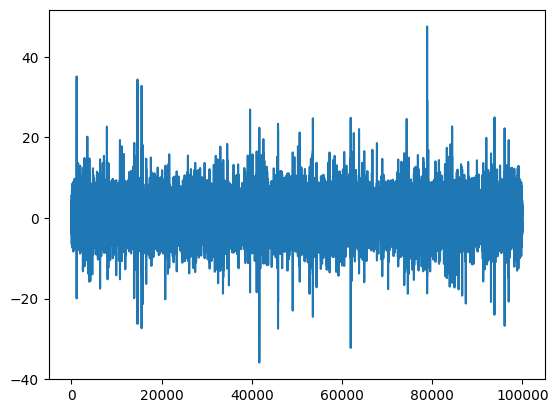

Параметры после оптимизации: alpha = 0.5046, beta_0 = 0.9940, beta_1 = 0.2939, gamma = 0.6059. Log-правдоподобие: -241864.8670.
Реальные параметры: alpha = 0.5, beta_0 = 1, beta_1 = 0.3, gamma = 0.6. Log-Правдоподобие при этих параметрах: -241866.3299.


In [9]:
# генерим данные 
alpha = 0.5
beta_0 = 1
beta_1 = 0.3
gamma = 0.6 
sigma_0sq = (beta_0 / (1 - beta_1 - gamma)) # попробуем делать массив sigma^2

z = norm.rvs(loc=0, scale=1, size=100000, random_state=42) # вектор z_t

# посчитаем массив sigma, epsilon
sigmasq = [sigma_0sq]
epsilon = [sigmasq[0] * z[0]]
for i in range(1, len(z)):
    sigmasq.append(beta_0 + beta_1 * epsilon[i - 1]**2 + gamma * sigmasq[i - 1])
    epsilon.append((sigmasq[i] ** 0.5) * z[i])

# посчитаем массив y
y = []
for i in range(len(z)):
    y.append(alpha + epsilon[i])

plt.plot(y)
plt.show()

start_theta = [0.1, 0.1, 0.1, 0.1]


# ищем максимум правдоподобия

def optimize_function(theta):
    return -1 * calc_log_likelhood(t=100000, y=y, theta=theta)

result = minimize(optimize_function, start_theta, bounds=[(0.01, 0.6), (0, 1.5), (0, 0.34), (0, 0.64)])

print(f'Параметры после оптимизации: alpha = {result.x[0]:.4f}, beta_0 = {result.x[1]:.4f}, beta_1 = {result.x[2]:.4f}, gamma = {result.x[3]:.4f}. Log-правдоподобие: {-1 * result.fun:.4f}.')

true_log_likelhood = calc_log_likelhood(t=100000, y=y, theta=[0.5, 1, 0.3, 0.6])
print(f'Реальные параметры: alpha = {0.5}, beta_0 = {1}, beta_1 = {0.3}, gamma = {0.6}. Log-Правдоподобие при этих параметрах: {true_log_likelhood:.4f}.')

### 2. Модель с переключением

Обозначения: 

### Модель и обозначения: 
Задана марковская цепь $\{s_t\}$ с 2-мя состояниями $\{1, 2\}$.

$p_{11}, p_{12}, p_{21}, p_{22}$ -- переходные вероятности

$\xi_{1|0}$ -- вектор начального распределения   



Рассматриваем GARCH, параметры которого индексированы $\{s_t\}$:

$$y_t = \alpha^{s_t} + \varepsilon_t$$
$$\varepsilon_t = \sigma_t z_t$$
$$z_t \sim iid \mathcal{N}(0, 1)$$
$$\sigma_t^2 = \beta_0^{s_t} + \beta_1^{s_t} \epsilon_{t-1}^2 + \gamma^{s_t} \sigma_{t-1}^2$$


### Задача:
Дано: $(y_1, y_2, ..., y_T) = Y$ 

Оценить параметры $\theta_1 = (\alpha^1, \beta_0^1, \beta_1^1, \gamma^1)$, $\theta_2 = (\alpha^2, \beta_0^2, \beta_1^2, \gamma^2)$ 

Гипотеза:

$$L(y_t | y_1, ..., y_{t-1},s_t = 1) = L(y_t | y_1, ..., y_{t-1}, s_t = 1, s_{t-1} = 1) \frac{p_{11} \mathbb{P}(s_{t-1} = 1)}{\mathbb{P}(s_{t} = 1)} + L(y_t | y_1, ..., y_{t-1}, s_t = 1, s_{t-1} = 2) \frac{p_{21} \mathbb{P}(s_{t-1} = 2)}{\mathbb{P}(s_{t} = 1)} $$


$L(y_t | y_1, ..., y_{t-1}, s_t = 1, s_{t-1} = 1,2)$ можно посчитать рекурсивно

Вероятности $\mathbb{P}(s_t = 1, 2)$ тоже понятно, как посчитать 

Вычисляем 

## Пробую нагенирорвать данные для модели с марковским переключением


Значения МЦ состояний: [1, 2, 1, 2, 2, 2, 1, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 1, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 1, 2, 1, 1, 2, 2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 1, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 1, 2, 2, 1, 2, 1, 2, 2, 2, 1, 1, 2, 2, 1, 1, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 2, 2, 1, 2, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 2, 1, 2, 2, 1, 2, 2]
[np.float64(2.0707480695568794), np.float64(0.45599806248227404), np.float64

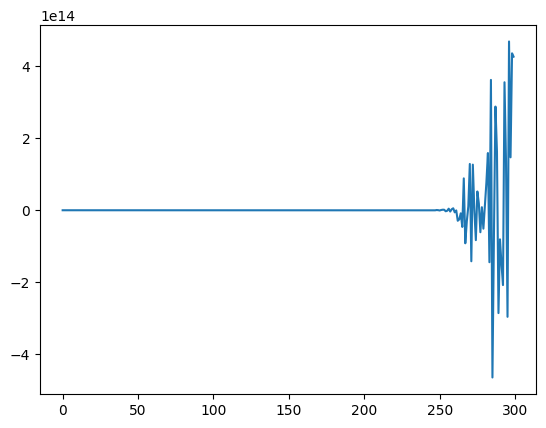

In [79]:
# генерим данные 

# генерим состояния марковской цепи

p_11 = 0.3
p_12 = 0.7
p_21 = 0.4
p_22 = 0.6
t = 300
xi_10 = [0.5, 0.5]

import random 
s = [random.choices([1, 2], weights=xi_10)[0]]
for i in range(1, t):
    if s[i - 1] == 1:
        s.append(random.choices([1, 2], weights=[p_11, p_12])[0])
    else: s.append(random.choices([1, 2], weights=[p_21, p_22])[0])

print(f'Значения МЦ состояний: {s}')


# задаем 2 значения для каждого параметра
alpha = [0.5, 1]
beta_0 = [1, 2]
beta_1 = [0.3, 0.6]
gamma = [0.6, 1.2] 

if s[0] == 1: sigma_0sq = (beta_0[0] / (1 - beta_1[0] - gamma[0])) 
else: sigma_0sq = (beta_0[1] / (2 - beta_1[1] - gamma[1]))

z = norm.rvs(loc=0, scale=1, size=len(s), random_state=42) # вектор z_t

# посчитаем массив sigma, epsilon
sigmasq = [sigma_0sq]
epsilon = [sigma_0sq**0.5 * z[0]]
for i in range(1, len(z)):
    if s[i] == 1:
        sigmasq.append(beta_0[0] + beta_1[0] * epsilon[i - 1]**2 + gamma[0] * sigmasq[i - 1])
        epsilon.append((sigmasq[i]**0.5) * z[i])
    else:
        sigmasq.append(beta_0[1] + beta_1[1] * epsilon[i - 1]**2 + gamma[1] * sigmasq[i - 1])
        epsilon.append((sigmasq[i]**0.5) * z[i])

# посчитаем массив y
y = []
for i in range(len(z)):
    if s[i] == 1: y.append(alpha[0] + epsilon[i])
    else: y.append(alpha[1] + epsilon[i])

print(y)

plt.plot(y)
plt.show()

In [70]:
print(s)

[1, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 2, 1, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 1, 1, 2, 1, 2, 2, 1, 2, 2, 1, 1, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 2, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1, 2, 2, 1, 1, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 2, 1, 2, 2, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 2, 1, 2, 1, 1, 2, 2, 1, 2, 1, 2, 1, 1, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 